In [45]:
from theFuncs import *

# DATA

In [46]:
# load_DTB3_SPY().to_csv('./data/spy_dtb3.csv')

In [47]:
sp100 = os.listdir(os.getcwd()+'/data/stock_dfs')
sp100_tickers = []
for csvfile in sp100:
    sp100_tickers.append(csvfile[:-4])

# sp100_tickers

In [48]:
ticker_data = get_ticker_data_multisource(
    sp100_tickers, 
    start="2010-01-02", 
    end="2021-11-01"
)
#start=2019-01-02
#end=2021-11-01

In [49]:
# nyse_tickers_cap = pd.read_csv("data/tickers_nyse.csv", index_col=0).MarketCap.dropna().apply(
#     lambda x: float(x[1: -1]) * 1e6 if x[-1] == "M" else float(x[1: -1]) * 1e6
# ).sort_values(ascending=False)[:200]

# nyse_tickers = nyse_tickers_cap.index

In [50]:
# nyse_ticker_weights = nyse_tickers_cap / nyse_tickers_cap.sum()
# nyse_ticker_weights.head()

In [51]:
# ticker_data = get_ticker_data_multisource(nyse_tickers)

In [52]:
tickers = sp100_tickers

model = RollingOLS.from_formula(
        "(ret - DTB3) ~ (spy_ret - DTB3)", 
        data = ticker_data.loc[tickers[0]], 
        window = 66
    ).fit(params_only=True)
df = model.params
df.columns = ["alpha", "Beta"]
df['ticker'] = tickers[0]
df.set_index('ticker', inplace=True, append=True)
df = df.reorder_levels(['ticker', 'date']).sort_index()


for ticker in tickers[1:]:
    try:
        model = RollingOLS.from_formula(
            "(ret - DTB3) ~ (spy_ret - DTB3)", 
            data = ticker_data.loc[ticker], 
            window = 66
        ).fit(params_only=True)

        temp = model.params
        temp.columns = ["alpha", "Beta"]
        temp['ticker'] = ticker
        temp.set_index('ticker', inplace=True, append=True)
        temp = temp.reorder_levels(['ticker', 'date']).sort_index()
        df = pd.concat(
            [ 
                df, 
                temp
            ]
        )
    except:
        continue

ticker_data = ticker_data.join(df)

ticker_data.head()

high       low      open     close       volume  \
ticker date                                                              
AAPL   2010-01-05  7.699643  7.616071  7.664286  7.656429  601904800.0   
       2010-01-06  7.686786  7.526786  7.656429  7.534643  552160000.0   
       2010-01-07  7.571429  7.466071  7.562500  7.520714  477131200.0   
       2010-01-08  7.571429  7.466429  7.510714  7.570714  447610800.0   
       2010-01-11  7.607143  7.444643  7.600000  7.503929  462229600.0   

                        ret  spy_close    DTB3   spy_ret  alpha  Beta  
ticker date                                                            
AAPL   2010-01-05  0.001729  90.443817  0.0007  0.002647    NaN   NaN  
       2010-01-06 -0.015906  90.507469  0.0006  0.000704    NaN   NaN  
       2010-01-07 -0.001849  90.889534  0.0005  0.004221    NaN   NaN  
       2010-01-08  0.006648  91.192001  0.0005  0.003328    NaN   NaN  
       2010-01-11 -0.008821  91.319382  0.0004  0.001397    NaN   NaN

In [53]:
market_caps = pd.DataFrame(
    ticker_data.close * ticker_data.volume,
    columns=["MarketCap"]
)
market_caps.head()

MarketCap
ticker date                    
AAPL   2010-01-05  4.608441e+09
       2010-01-06  4.160329e+09
       2010-01-07  3.588367e+09
       2010-01-08  3.388733e+09
       2010-01-11  3.468538e+09

In [54]:
market_caps = market_caps.ewm(66).mean()

In [55]:
market_caps.head()

MarketCap
ticker date                    
AAPL   2010-01-05  4.608441e+09
       2010-01-06  4.382700e+09
       2010-01-07  4.113931e+09
       2010-01-08  3.928522e+09
       2010-01-11  3.833738e+09

In [56]:
ticker_data_wide = ticker_data.reset_index(level=['ticker', 'date'])
ticker_data_wide = ticker_data_wide[['ticker', 'date', 'ret']].pivot(
    index='date', 
    columns='ticker', 
    values='ret'
)
ticker_data_wide.head()

ticker,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMGN,AMT,AMZN,AVGO,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,0.001729,NaN,-0.008079,0.006180,0.016446,-0.018735,-0.008663,0.016567,0.005900,0.007423,...,-0.001586,0.013917,0.001719,0.025350,-0.011459,0.001803,-0.008043,0.027452,-0.009958,0.003905
2010-01-06,-0.015906,NaN,0.005553,0.010631,-0.002122,-0.006478,-0.007515,0.005206,-0.018116,0.007895,...,0.009848,0.001508,-0.007378,0.010656,-0.013428,-0.042591,-0.007568,0.001425,-0.002235,0.008643
2010-01-07,-0.001849,NaN,0.008284,-0.000935,-0.019405,-0.019218,-0.009157,-0.002702,-0.017013,-0.006266,...,0.038377,-0.008886,-0.007606,0.019401,0.009307,-0.005952,0.005991,0.036286,0.000560,-0.003142
2010-01-08,0.006648,NaN,0.005112,-0.003978,-0.005422,0.026592,0.008886,0.002032,0.027077,0.007357,...,-0.009391,0.033885,0.048075,0.001655,0.002766,0.000630,0.001354,-0.009269,-0.005037,-0.004012
2010-01-11,-0.008821,NaN,0.005086,-0.000940,-0.013083,0.009884,0.004404,-0.009013,-0.024041,0.006260,...,0.006728,-0.006614,0.044042,0.004544,-0.002874,0.004094,0.001622,-0.002079,0.016501,0.011220


In [57]:
rolling_correlations = ticker_data_wide.rolling(66).corr().fillna(0)
rolling_correlations.head()

ticker             AAPL  ABBV  ABT  ACN  ADBE  AIG  AMGN  AMT  AMZN  AVGO  \
date       ticker                                                           
2010-01-05 AAPL     0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ABBV     0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ABT      0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ACN      0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ADBE     0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   

ticker             ...  UNH  UNP  UPS  USB    V   VZ  WBA  WFC  WMT  XOM  
date       ticker  ...                                                    
2010-01-05 AAPL    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ABBV    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ABT     ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ACN     ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ADBE    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 101 columns]

In [58]:
filter_correlations = rolling_correlations.groupby(["date"]).sum().sum(axis=1)
filter_correlations_dates = filter_correlations[filter_correlations > 0].index
rolling_correlations = rolling_correlations.loc[filter_correlations_dates]

In [59]:
rolling_covariances = ticker_data_wide.rolling(66).cov().fillna(0)
rolling_covariances.head()

ticker             AAPL  ABBV  ABT  ACN  ADBE  AIG  AMGN  AMT  AMZN  AVGO  \
date       ticker                                                           
2010-01-05 AAPL     0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ABBV     0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ABT      0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ACN      0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   
           ADBE     0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0   0.0   0.0   

ticker             ...  UNH  UNP  UPS  USB    V   VZ  WBA  WFC  WMT  XOM  
date       ticker  ...                                                    
2010-01-05 AAPL    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ABBV    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ABT     ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ACN     ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
           ADBE    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 101 columns]

In [60]:
filter_covariances = rolling_covariances.groupby(["date"]).sum().sum(axis=1)
filter_covariances_dates = filter_covariances[filter_covariances > 0].index
rolling_covariances = rolling_covariances.loc[filter_covariances_dates]

In [61]:
rolling_covariances.loc[('2019-06-24', 'AAPL'), 'AAPL']

date        ticker
2019-06-24  AAPL      0.000275
Name: AAPL, dtype: float64

In [62]:
# ticker_data.to_csv("data/test_run/ticker_data.csv")
# ticker_data_wide.to_csv("data/test_run/ticker_data_wide.csv")
# rolling_correlations.to_csv("data/test_run/rolling_correlations.csv")
# rolling_covariances.to_csv("data/test_run/rolling_covariances.csv")
# market_caps.to_csv("data/test_run/market_caps.csv")

In [63]:
# ticker_data = pd.read_csv("data/test_run/ticker_data.csv", index_col=[0, 1], parse_dates=True)
# ticker_data_wide = pd.read_csv("data/test_run/ticker_data_wide.csv", index_col=0, parse_dates=True)
# rolling_correlations = pd.read_csv("data/test_run/rolling_correlations.csv", index_col=[0, 1], parse_dates=True)
# rolling_covariances = pd.read_csv("data/test_run/rolling_covariances.csv", index_col=[0, 1], parse_dates=True)
# market_caps = pd.read_csv("data/test_run/market_caps.csv", index_col=[0, 1], parse_dates=True)

# CLUSTERING

In [64]:
date = get_closest_trading_day("2007-07-07", rolling_correlations)
K = 10

In [65]:
x, y, z = clustering_model(rolling_correlations, date, K, GRB.MAXIMIZE)

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 10303 rows, 10302 columns and 30704 nonzeros
Model fingerprint: 0x12fd8a16
Variable types: 0 continuous, 10302 integer (10302 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-04, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 30.9114853
Presolve time: 0.05s
Presolved: 10303 rows, 10302 columns, 30704 nonzeros
Variable types: 0 continuous, 10302 integer (10302 binary)

Root relaxation: objective 5.786777e+01, 879 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      57.8677744   57.86777  0.00%     -    0s

Explored 0 nodes (879 simplex iterations) in 0.10 seconds
Thread count was

# INDEX BY CLUSTER WEIGHTS

In [66]:
z_market_cap = market_caps.loc[
    market_caps.index.get_level_values(1) == date
].join(z)
z_market_cap.reset_index(drop=True, level=1, inplace=True)

In [67]:
center_weights = z_market_cap[(z_market_cap.in_center == 1) & (z_market_cap.is_center == 1)].groupby("center").MarketCap.sum() / z_market_cap[(z_market_cap.in_center == 1) & (z_market_cap.is_center == 1)].MarketCap.sum()

In [68]:
portfolio_returns = get_portfolio_returns(
    center_weights, date, ticker_data_wide
)
spy_returns = get_spy_returns(date)

portfolio_returns, spy_returns

(0.9305891657319043, 0.91330845560214)

In [69]:
portfolio_returns - spy_returns

0.017280710129764287

In [70]:
get_portfolio_beta(center_weights, date, ticker_data)

1.1796735231671152

In [71]:
# master_func("2020-03-23", K, rolling_correlations, market_caps, ticker_data, ticker_data_wide, rolling_covariances, 0.5, 1.5, 1e-3)

# INDEX BY MIN VAR

In [72]:
mean_var_step, obj = mean_variance_model(
    market_caps, 
    ticker_data, 
    date, 
    rolling_covariances, 
    center_weights,
    0.5, 
    1.5, 
    1e-3
)

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 88 rows, 94 columns and 457 nonzeros
Model fingerprint: 0x61f83a68
Model has 4371 quadratic objective terms
Coefficient statistics:
  Matrix range     [8e-06, 2e+00]
  Objective range  [4e-05, 3e-04]
  QObjective range [3e-07, 4e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 2e+00]
Presolve removed 85 rows and 84 columns
Presolve time: 0.00s
Presolved: 3 rows, 11 columns, 31 nonzeros
Presolved model has 55 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 9
 AA' NZ     : 6.600e+01
 Factor NZ  : 7.800e+01
 Factor Ops : 6.500e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.49554563e+05 -1.49614319e+05  8.25e+03 7.34e-03  3.57e+05     0s
   1   1.4

In [73]:
obj

0.0056193105661010295

In [74]:
mean_var_step_return = get_portfolio_returns(mean_var_step.weights, date, ticker_data_wide)
mean_var_step_return, spy_returns

(0.8779818795229534, 0.91330845560214)

In [75]:
mean_var_step_return - spy_returns

-0.035326576079186656

In [76]:
get_portfolio_beta(mean_var_step.weights, date, ticker_data)

0.9163483339675249

# Method Comparison

In [77]:
pd.concat(
    [
        mean_var_step[mean_var_step.weights > 0], 
        center_weights
    ], 
    axis=1
)

,weights,MarketCap
HD,5.698713e-01,0.019094
INTC,2.842412e-01,0.269206
JPM,1.030529e-01,0.182216
SO,3.260455e-02,0.074095
COF,8.972974e-03,0.030236
CRM,1.253450e-03,0.059889
CVX,2.506931e-06,0.192577
PG,7.436261e-07,0.047384
GOOG,1.878246e-07,0.064810
MRK,1.814262e-07,0.060495


# Master Func

In [78]:
start_date = get_closest_trading_day("2000-01-01", rolling_correlations)
end_date = max(ticker_data.index.get_level_values("date"))

master_cluster_index = {}
master_cluster_performance = {}
master_mean_var_index = {}
master_mean_var_performance = {}

while start_date < end_date:
    master_func(
        start_date, 
        10, 
        rolling_correlations, 
        market_caps, 
        ticker_data, 
        ticker_data_wide, 
        rolling_covariances,
        0.5, 
        1.5, 
        1e-3, 
        master_cluster_index,
        master_cluster_performance,
        master_mean_var_index,
        master_mean_var_performance, 
        # GRB.MINIMIZE
        )

    start_date += relativedelta(months=3)

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 10303 rows, 10302 columns and 30704 nonzeros
Model fingerprint: 0x12fd8a16
Variable types: 0 continuous, 10302 integer (10302 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-04, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 30.9114853
Presolve time: 0.05s
Presolved: 10303 rows, 10302 columns, 30704 nonzeros
Variable types: 0 continuous, 10302 integer (10302 binary)

Root relaxation: objective 5.786777e+01, 879 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      57.8677744   57.86777  0.00%     -    0s

Explored 0 nodes (879 simplex iterations) in 0.11 seconds
Thread count was

In [79]:
method1_index = pd.DataFrame.from_dict(master_cluster_index, orient="index")
method1_index

weight
2010-04-09 COF   0.030236
           CRM   0.059889
           CVX   0.192577
           GOOG  0.064810
           HD    0.019094
...                   ...
2021-10-08 JNJ   0.068474
           MDLZ  0.043977
           MET   0.166555
           RTX   0.064563
           SO    0.012109

[470 rows x 1 columns]

In [89]:
# method1_index.to_csv("./output/method1_index.csv")

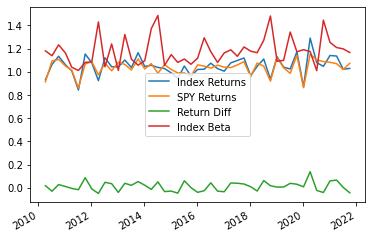

In [98]:
method1_performance = pd.DataFrame.from_dict(master_cluster_performance, orient="index")
method1_performance.plot()
# plt.savefig("./output/method1_performance_plot.png")

In [90]:
# method1_performance.to_csv("./output/method1_performance.csv")

In [81]:
method2_index = pd.DataFrame.from_dict(master_mean_var_index, orient="index")
method2_index

weight
2010-04-09 COF   8.972974e-03
           CRM   1.253450e-03
           CVX   2.506931e-06
           GOOG  1.878246e-07
           HD    5.698713e-01
...                       ...
2021-10-08 JNJ   9.572099e-08
           MDLZ  6.412723e-08
           MET   2.985292e-01
           RTX   4.450538e-04
           SO    2.046981e-04

[400 rows x 1 columns]

In [91]:
# method2_index.to_csv("./output/method2_index.csv")

In [82]:
# method2_index.index.names = ['date', 'ticker']

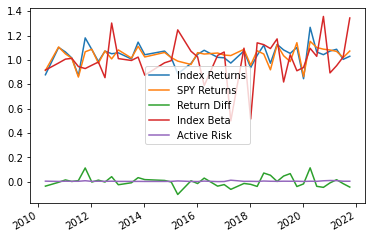

In [99]:
method2_performance = pd.DataFrame.from_dict(master_mean_var_performance, orient="index")
method2_performance.plot()
# plt.savefig("./output/method2_performance_plot.png")

In [92]:
# method2_performance.to_csv("./output/method2_performance.csv")

In [84]:
comp_index = method1_index.join(
    method2_index, 
    lsuffix=" method 1", 
    rsuffix=" method 2"
)
comp_index

weight method 1  weight method 2
2010-04-09 COF          0.030236     8.972974e-03
           CRM          0.059889     1.253450e-03
           CVX          0.192577     2.506931e-06
           GOOG         0.064810     1.878246e-07
           HD           0.019094     5.698713e-01
...                          ...              ...
2021-10-08 JNJ          0.068474     9.572099e-08
           MDLZ         0.043977     6.412723e-08
           MET          0.166555     2.985292e-01
           RTX          0.064563     4.450538e-04
           SO           0.012109     2.046981e-04

[470 rows x 2 columns]

In [93]:
# comp_index.to_csv("./output/comp_index.csv")

In [85]:
comp_performance = method1_performance.join(
    method2_performance, 
    lsuffix=" Method 1", 
    rsuffix=" Method 2"
).fillna(method="ffill")
comp_performance

,Index Returns Method 1,SPY Returns Method 1,Return Diff Method 1,Index Beta Method 1,Index Returns Method 2,SPY Returns Method 2,Return Diff Method 2,Index Beta Method 2,Active Risk
2010-04-09,0.930589,0.913308,0.017281,1.179674,0.877982,0.913308,-0.035327,0.916348,0.005619
2010-07-09,1.062880,1.093355,-0.030475,1.137867,0.877982,0.913308,-0.035327,0.916348,0.005619
2010-10-08,1.133418,1.105971,0.027447,1.231904,1.102187,1.105971,-0.003784,0.974607,0.003311
2011-01-10,1.060095,1.049529,0.010566,1.161905,1.065281,1.049529,0.015752,1.006178,0.005207
2011-04-08,1.006953,1.013098,-0.006145,1.038203,1.015997,1.013098,0.002898,1.012733,0.004530
2011-07-08,0.842012,0.859254,-0.017242,1.010844,0.869442,0.859254,0.010188,0.945348,0.004559
2011-10-10,1.152838,1.066635,0.086203,1.079946,1.180426,1.066635,0.113791,0.928967,0.009037
2012-01-09,1.076709,1.087039,-0.010330,1.085624,1.085255,1.087039,-0.001784,0.956017,0.003912
2012-04-09,0.923211,0.973039,-0.049828,1.429148,0.987021,0.973039,0.013982,0.982358,0.004970
2012-07-09,1.120222,1.073640,0.046581,1.042312,1.071959,1.073640,-0.001681,0.854286,0.004148


In [94]:
# comp_performance.to_csv("./output/comp_performance.csv")

In [96]:
return_comp_performance = comp_performance[
    ["Return Diff Method 1", "Return Diff Method 2"]
].add(1).cumprod().fillna(method="ffill")
return_comp_performance

,Return Diff Method 1,Return Diff Method 2
2010-04-09,1.017281,0.964673
2010-07-09,0.986279,0.930595
2010-10-08,1.013350,0.927074
2011-01-10,1.024057,0.941677
2011-04-08,1.017764,0.944406
2011-07-08,1.000215,0.954028
2011-10-10,1.086437,1.062587
2012-01-09,1.075214,1.060692
2012-04-09,1.021638,1.075522
2012-07-09,1.069227,1.073714


In [97]:
# return_comp_performance.to_csv("./output/return_comp_performance.csv")

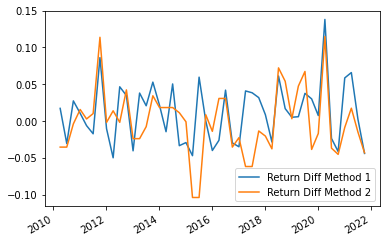

In [100]:
comp_performance.plot(y=["Return Diff Method 1", "Return Diff Method 2"])
# plt.savefig("./output/comp_return_plot.png")

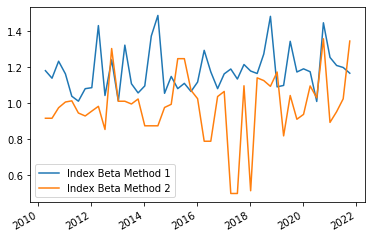

In [101]:
comp_performance.plot(y=["Index Beta Method 1", "Index Beta Method 2"])
# plt.savefig("./output/comp_beta_plot.png")